# Extended Connectivity Fingerprint-based Chemical Structural Distance Metric

This notebook provides a pipeline of a new Machine Learning-based similarity/distance metric that better characterize the reaction distance (defined by minimum reaction steps required to transform a group of precursors to a target compound). The performance of predicting the number of reaction steps that connects two groups of compounds are shown below. Here, only compounds/reactions from MetaNetX is considered so the predictions are NOT comparable to that of the model trained on synthetic data collected through expanding plausible reaction networks with "transformation rules", which is part of a different project.

## Header and Import

In [1]:
#--------------------------------------------------#
import os 
import sys
import os.path
from sys import platform
from pathlib import Path
#--------------------------------------------------#
if os.name == 'nt' or platform == 'win32':
    print("Running on Windows")
    if 'ptvsd' in sys.modules:
        print("Running in Visual Studio")
        try:
            os.chdir(os.path.dirname(__file__))
            print('CurrentDir: ', os.getcwd())
        except:
            pass
#--------------------------------------------------#
    else:
        print("Running outside Visual Studio")
        try:
            if not 'workbookDir' in globals():
                workbookDir = os.getcwd()
                print('workbookDir: ' + workbookDir)
                os.chdir(workbookDir)
        except:
            pass
#--------------------------------------------------#
from rdkit import Chem
from rdkit.Chem import AllChem
#--------------------------------------------------#
import ast
import copy
import time
import scipy
import random
import pickle
import scipy.io
import warnings
import argparse
import subprocess
import numpy as np
import pandas as pd
from numpy import *
from tqdm import tqdm
from pathlib import Path
from random import shuffle

Running on Windows
Running outside Visual Studio
workbookDir: C:\Users\ZhiqingXu_AMD\Desktop\DM_3.10\MNX-VAE_v3.10


## Xtep10.3 Decision-Tree Model trained on Processed Reaction Dataset

In [2]:
# Xtep10.3 Imports
#--------------------------------------------------#
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AtomPairs import Pairs
from rdkit.Chem.AtomPairs import Torsions
from rdkit.Chem.Fingerprints import FingerprintMols
#--------------------------------------------------#
import ast
import copy
import time
import scipy
import random
import pickle
import scipy.io
import argparse
import subprocess
import numpy as np
import pandas as pd
from numpy import *
from tqdm import tqdm
from pathlib import Path
from random import shuffle
#--------------------------------------------------#
from sklearn import datasets
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler   
from sklearn.model_selection import train_test_split
#--------------------------------------------------#
from sklearn import svm
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix, classification_report
#--------------------------------------------------#
from sklearn.manifold import TSNE
#from sklearn.tree import DecisionTreeRegressor
#from sklearn.model_selection import GridSearchCV
#--------------------------------------------------#
import seaborn as sns
import matplotlib as mpl
import matplotlib.pylab as pl
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
#--------------------------------------------------#
from scipy import stats
from pathlib import Path
from copy import deepcopy
from datetime import datetime
from tpot import TPOTRegressor
from ipywidgets import IntProgress
#--------------------------------------------------#
from AP_RDKIT_FP import *
from Step07_NetworkToDistance import *


running on windows
running outside visual studio
workbookdir: C:\Users\ZhiqingXu_AMD\Desktop\DM_3.10\MNX-VAE_v3.10
Running on Windows
Running outside Visual Studio
workbookDir: C:\Users\ZhiqingXu_AMD\Desktop\DM_3.10\MNX-VAE_v3.10


C:\Anaconda3\envs\rdkit3\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


### Xtep10.3.1 Select Input parameters

In [3]:
#--------------------------------------------------#
# Random Seeds
seed=42
random.seed(seed)
np.random.seed(seed)
#--------------------------------------------------#
# Args
THRESHOLD = 6
#--------------------------------------------------#
# Data related parameters
#-------------------      0        1        2        3          4         5        6     
ECFP_encodings_list = ["ECFP2", "ECFP4", "ECFP6", "JTVAE", "MorganFP", "ECFP8", "ECFPX"]
ECFP_encodings = ECFP_encodings_list[0]
ECFP_type = ECFP_encodings[-1] if ECFP_encodings in ["ECFP2", "ECFP4", "ECFP6"] else "6" # 2, 4, 6
#--------------------------------------------------#
# Data imports
Step_code = "Xtep10_MNX_ECFP_DT"
data_folder = Path("MNX_ECFP_savings/")
data_file="Xtep09_processed_data_" + ECFP_encodings
#--------------------------------------------------#
# Prediction parameter settings
model_type_list=["Reg", "Clf"] # Reg for ordinal Regression
model_type=model_type_list[1]
#--------------------------------------------------#
# Results savings
results_folder = Path("MNX_ECFP_savings/" + Step_code +"_results/")
if not os.path.exists(results_folder):
    os.makedirs(results_folder)
output_file_3 = Step_code + "_all_X_y.p"
output_file_header = Step_code + "_result_"

### Xtep10.3.2 Create Temporary Folder for Saving Results

In [4]:
# Create Temp Folder for Saving Results
print(">>>>> Creating temporary subfolder and clear past empty folders! <<<<<")
now = datetime.now()
#d_t_string = now.strftime("%Y%m%d_%H%M%S")
d_t_string = now.strftime("%m%d-%H%M%S")
#====================================================================================================#
# REMOVE PREVIOUS EMPTY FOLDERS !!!!!
results_folder_contents = os.listdir(results_folder)
for item in results_folder_contents:
    if os.path.isdir(results_folder / item):
        try:
            os.rmdir(results_folder / item)
            print("Remove empty folder " + item + "!")
        except:
            #print("Found Non-empty folder " + item + "!")
            pass
temp_folder_name = Step_code + ECFP_type + "_" + d_t_string + "_" + model_type
results_sub_folder = results_folder / (temp_folder_name +"/")
if not os.path.exists(results_sub_folder):
    os.makedirs(results_sub_folder)
print(">>>>> Temporary subfolder created! <<<<<")

>>>>> Creating temporary subfolder and clear past empty folders! <<<<<
>>>>> Temporary subfolder created! <<<<<


In [5]:
class Tee(object):
    def __init__(self, *files):
        self.files = files
    def write(self, obj):
        for f in self.files:
            f.write(obj)
            f.flush() # If you want the output to be visible immediately
    def flush(self) :
        for f in self.files:
            f.flush()
#--------------------------------------------------#
orig_stdout = sys.stdout
f = open(results_sub_folder / 'print_out.txt', 'w')
#sys.stdout = Tee(sys.stdout, f)
print("="*50)
#--------------------------------------------------#
print("Xtep_code: ", Step_code)
#--------------------------------------------------#
print("ECFP_encodings: ", ECFP_encodings)
#--------------------------------------------------#
print("model_type: ", model_type)
print("="*50)

Xtep_code:  Xtep10_MNX_ECFP_DT
ECFP_encodings:  ECFP2
model_type:  Clf


### Xtep10.3.3 Import Processed Dataset

In [6]:
# Get Input files
# Get Sequence Embeddings from X03 pickles.
with open( data_folder / data_file, 'rb') as Step09_processed_data:
    processed_data_dict = pickle.load(Step09_processed_data)
X_data = processed_data_dict["X_data"]
y_data = processed_data_dict["y_data"]
#====================================================================================================#
y_data = [i if i<=THRESHOLD-1 else THRESHOLD for i in y_data]
#====================================================================================================#
print("max(y_data): ", max(y_data))
print("min(y_data): ", min(y_data))
num_classes=max(y_data)-min(y_data)+1
print("num_classes: ", num_classes)

max(y_data):  6
min(y_data):  1
num_classes:  6


### Xtep10.3.4 Use t-distributed stochastic neighbor embedding to Visualize the Dataset

Start tSNE ...


C:\Anaconda3\envs\rdkit3\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Anaconda3\envs\rdkit3\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 30000 samples in 0.070s...
[t-SNE] Computed neighbors for 30000 samples in 44.692s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30000
[t-SNE] Computed conditional probabilities for sample 2000 / 30000
[t-SNE] Computed conditional probabilities for sample 3000 / 30000
[t-SNE] Computed conditional probabilities for sample 4000 / 30000
[t-SNE] Computed conditional probabilities for sample 5000 / 30000
[t-SNE] Computed conditional probabilities for sample 6000 / 30000
[t-SNE] Computed conditional probabilities for sample 7000 / 30000
[t-SNE] Computed conditional probabilities for sample 8000 / 30000
[t-SNE] Computed conditional probabilities for sample 9000 / 30000
[t-SNE] Computed conditional probabilities for sample 10000 / 30000
[t-SNE] Computed conditional probabilities for sample 11000 / 30000
[t-SNE] Computed conditional probabilities for sample 12000 / 30000
[t-SNE] Computed conditional probabilities for sa

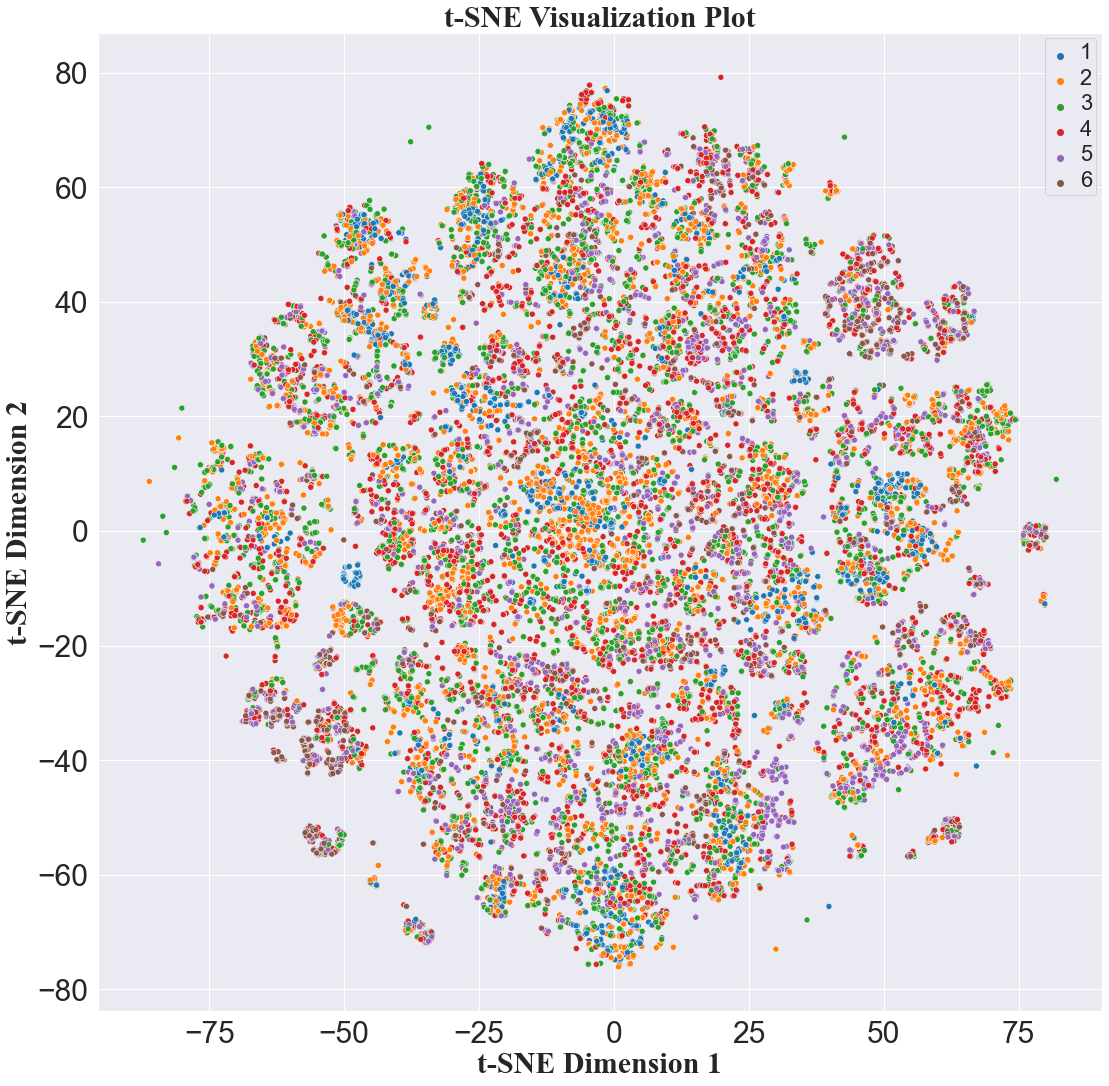

In [7]:
def tSNE_Visualization(X_data, y_data, num_classes):
    print ("Start tSNE ...")
    tsne = TSNE(n_components=2, verbose=1, random_state=42)
    X = tsne.fit_transform(X_data)
    df = pd.DataFrame()
    df["y"] = y_data
    df["tSNE_1"] = X[:,0]
    df["tSNE_2"] = X[:,1]
    print ("End tSNE.")
    #--------------------------------------------------#
    sns.set(style = "darkgrid")
    fig = plt.figure(figsize=(18,18))
    ax = sns.scatterplot(x = "tSNE_1", 
                         y = "tSNE_2", 
                         hue = df.y.tolist(),
                         palette = sns.color_palette("tab10", n_colors=num_classes),
                         #palette = sns.color_palette("hls", num_classes),
                         data=df
                         )
    #--------------------------------------------------#
    font = {'family' : "Times New Roman", 'weight' : 'bold', 'size': 30}
    plt.rc('font', **font)
    plt.rc('font', size=30)          # controls default text sizes
    plt.rc('axes', titlesize=30)     # fontsize of the axes title
    plt.rc('axes', labelsize=30)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=30)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=30)    # fontsize of the tick labels
    plt.rc('legend', fontsize=30)    # legend fontsize
    plt.rc('figure', titlesize=30)   # fontsize of the figure title
    plt.xticks(fontsize = 30)
    plt.yticks(fontsize = 30)
    plt.xlabel('t-SNE Dimension 1',**font)
    plt.ylabel('t-SNE Dimension 2',**font)
    plt.title('t-SNE Visualization Plot',**font)
    plt.setp(ax.get_legend().get_texts(), fontsize='22') # for legend text
    plt.setp(ax.get_legend().get_title(), fontsize='32') # for legend title
    #--------------------------------------------------#
    plt.show()
    fig.savefig(results_sub_folder / (output_file_header + ".04_t-SNE_plot_" +str(len(X_data))+".png") , dpi=500 ) 
    mpl.rcParams.update(mpl.rcParamsDefault)
    return

tSNE_Visualization(X_data[:30000], y_data[:30000], num_classes)

### Xtep10.3.5 t-SNE 3D plot

Start tSNE ...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1800 samples in 0.003s...
[t-SNE] Computed neighbors for 1800 samples in 0.176s...


C:\Anaconda3\envs\rdkit3\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Anaconda3\envs\rdkit3\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed conditional probabilities for sample 1000 / 1800
[t-SNE] Computed conditional probabilities for sample 1800 / 1800
[t-SNE] Mean sigma: 1.815020
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.791176
[t-SNE] KL divergence after 1000 iterations: 0.923687
End tSNE.


C:\Anaconda3\envs\rdkit3\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


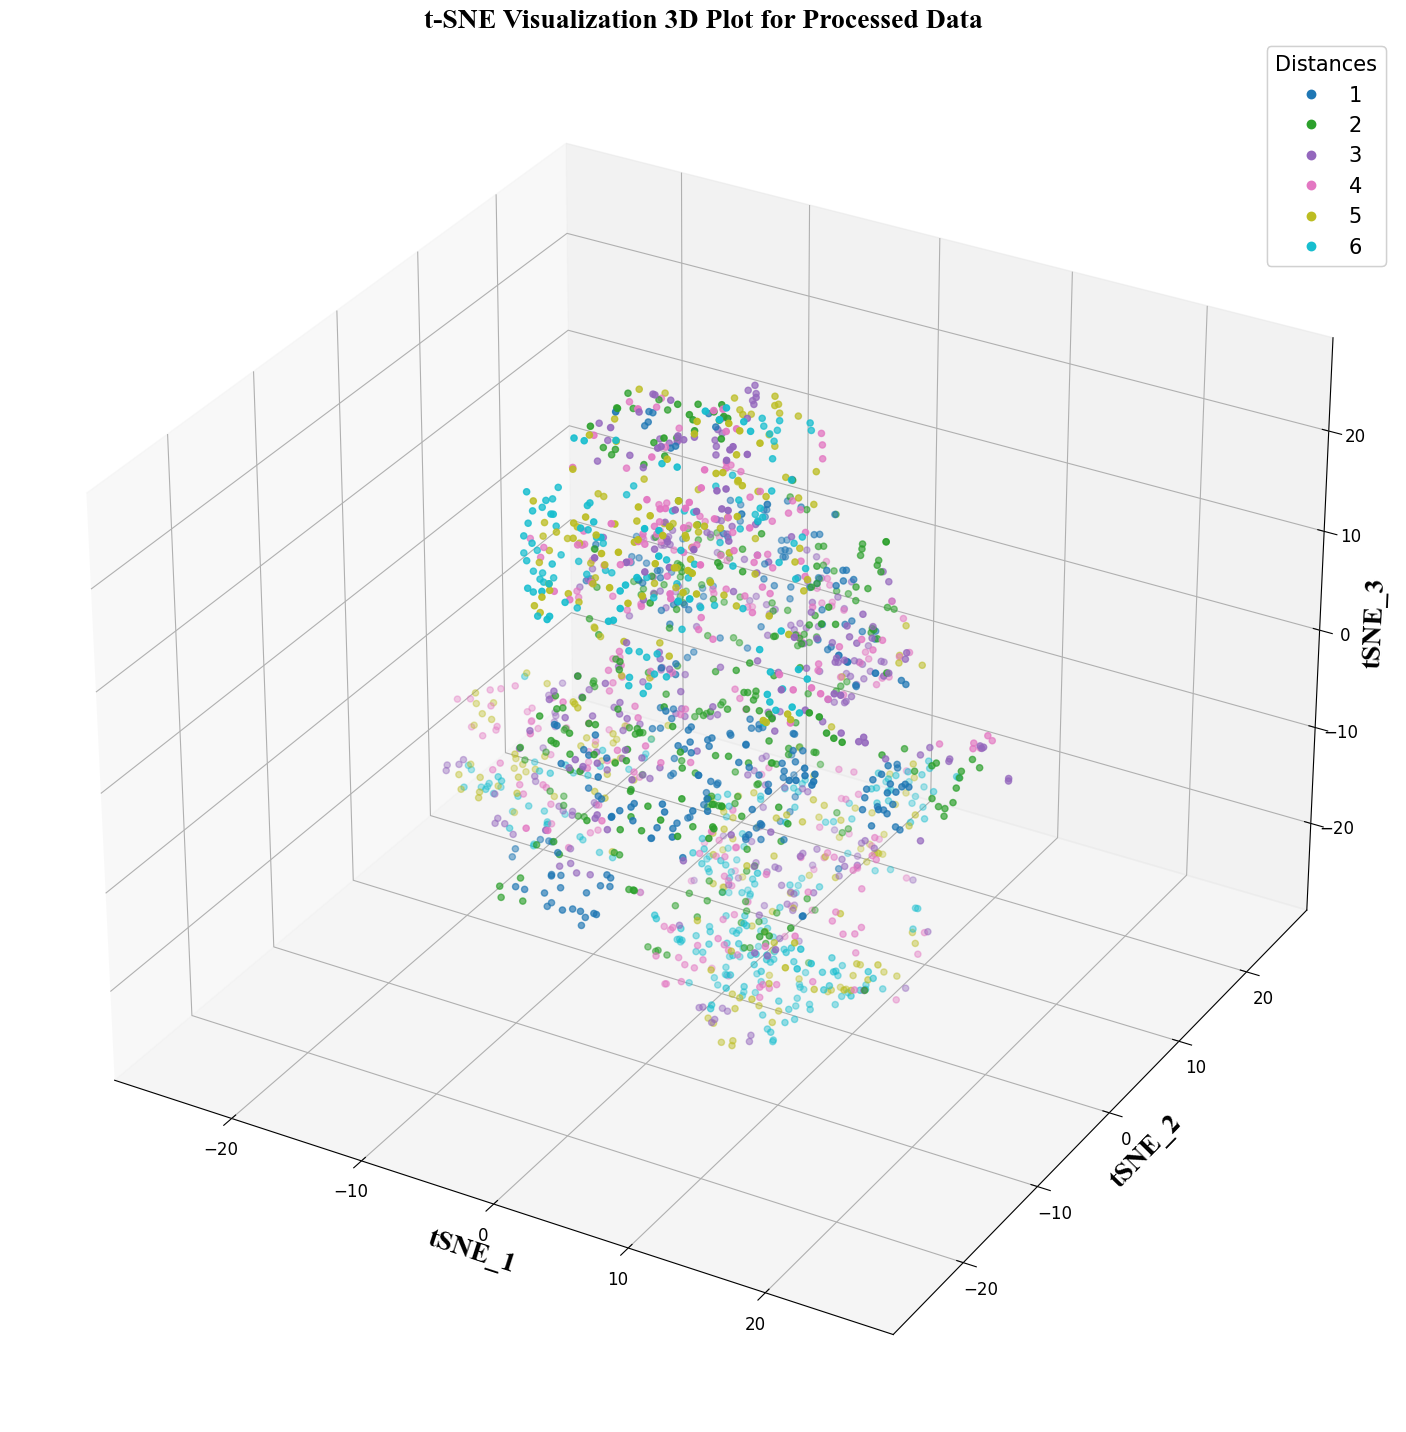

In [8]:
def tSNE_Visualization_3D(X_data, y_data, num_classes):
    print ("Start tSNE ...")
    tsne = TSNE(n_components=3, verbose=1, random_state=0)
    X = tsne.fit_transform(X_data)
    df = pd.DataFrame()
    df["y"] = y_data
    df["tSNE_1"] = X[:,0]
    df["tSNE_2"] = X[:,1]
    df["tSNE_3"] = X[:,2]
    print ("End tSNE.")
    labels_dict = dict([])
    for i in range(num_classes):
        labels_dict[i+1] = "d="+str(i+1)
    #--------------------------------------------------#
    font1 = {'family' : "Times New Roman", 'weight' : 'bold', 'size': 20}
    #--------------------------------------------------#
    ax = plt.figure(figsize=(18,18)).gca(projection='3d')
    sc = ax.scatter(
                    xs=df["tSNE_1"], 
                    ys=df["tSNE_2"], 
                    zs=df["tSNE_3"], 
                    c=df["y"], 
                    #palette=sns.color_palette("hls", num_classes),
                    cmap='tab10',
                    label = df["y"]
                    )
    lg = ax.legend(*sc.legend_elements(),
                    loc="best", 
                    title="Distances",
                    fontsize=15
                    )
    lg.get_title().set_fontsize('15') 
    ax.add_artist(lg)
    #--------------------------------------------------#
    ax.set_xlabel('tSNE_1', **font1)
    ax.set_ylabel('tSNE_2', **font1)
    ax.set_zlabel('tSNE_3', **font1)
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)
    ax.tick_params(axis="z", labelsize=12)
    #--------------------------------------------------#
    ax.set_xlim(-28,28)
    ax.set_ylim(-28,28)
    ax.set_zlim(-28,28)
    #--------------------------------------------------#
    plt.title('t-SNE Visualization 3D Plot for Processed Data', **font1)
    #--------------------------------------------------#
    fig = plt.gcf()
    fig.savefig(results_sub_folder / (output_file_header + ".05_t-SNE_plot3D_" +str(len(X_data))+".png") , dpi=500 ) 
    plt.show()
    mpl.rcParams.update(mpl.rcParamsDefault)
    return

tSNE_Visualization_3D(X_data[:1800], y_data[:1800], num_classes)

### 10.3.6 Create Labels Dictionary

In [9]:
# Define a dict since classes read by pytorch shall be {0,1,...C-1}
class2idx = dict([])
for i in range(10):
    class2idx[i+1]=i
idx2class = {v: k for k, v in class2idx.items()}
y_data = [class2idx[one_class] for one_class in y_data]

#print(y_data)

### 10.3.7 Data Split

In [10]:
# Data Split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, stratify=y_data, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.9, stratify=y_test, random_state=42)

print("data set size: ", len(y_data))
print("train set size: ", len(y_train))
print("valid set size: ", len(y_valid))
print("test set size: ", len(y_test))
print("X dimendion: ", len(X_data[0]))
print("="*50)


data set size:  170794
train set size:  119555
valid set size:  5123
test set size:  46116
X dimendion:  2093


In [11]:
## Normalize Inputs ? NO NEED TO NORMALIZE FOR DECISION TREE!!
#print("Normalizing Inputs... NOT necessary in this case.")
#scaler = MinMaxScaler()
#X_train = scaler.fit_transform(X_train)
#X_valid = scaler.transform(X_valid)
#X_test = scaler.transform(X_test)
#print("Normalized Inputs... NOT necessary in this case.")

X_train, y_train = np.array(X_train), np.array(y_train)
X_valid, y_valid = np.array(X_valid), np.array(y_valid)
X_test , y_test  = np.array(X_test) , np.array(y_test)


### 10.3.8 Use sns.barplot to Show the Distribution of Data Split

In [12]:
def get_class_distribution(obj, num_classes):

    count_dict_keys = ["d=" + str(i+1) for i in range(num_classes)]
    count_dict=dict([])
    for one_key in count_dict_keys:
        count_dict[one_key] = 0

    for i in obj:
        if i == 0: 
            count_dict['d=1'] += 1
        elif i == 1: 
            count_dict['d=2'] += 1
        elif i == 2: 
            count_dict['d=3'] += 1
        elif i == 3: 
            count_dict['d=4'] += 1  
        elif i == 4: 
            count_dict['d=5'] += 1        
        elif i == 5: 
            count_dict['d=6'] += 1
        elif i == 6: 
            count_dict['d=7'] += 1
        elif i == 7: 
            count_dict['d=8'] += 1
        elif i == 8: 
            count_dict['d=9'] += 1
        elif i == 9: 
            count_dict['d=10'] += 1
        else:
            print("Check classes.")
    return count_dict

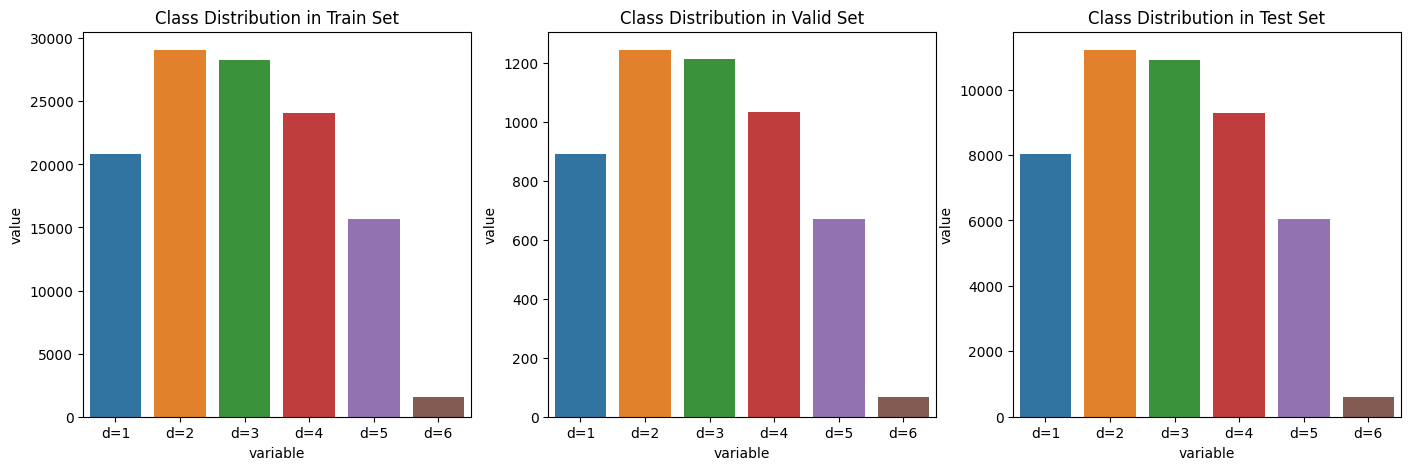

In [13]:
# Check the data splitting and confirm equal stratification in train/test/valid dataset.

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17,5))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train, num_classes)]).melt(), x = "variable", y="value",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_valid, num_classes)]).melt(), x = "variable", y="value",  ax=axes[1]).set_title('Class Distribution in Valid Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test, num_classes)]).melt(), x = "variable", y="value",  ax=axes[2]).set_title('Class Distribution in Test Set')

plt.show()

### 10.3.9 Train a Decision Tree Model

In [14]:
#Before training, define a function to calculate accuracy.

def multi_acc(y_pred, y_test): 
    correct_pred = (y_pred == y_test)
    acc = correct_pred.sum() / len(correct_pred)
    acc = round(acc * 1000) / 1000.
    return acc


In [15]:
print("Start DT Training...")
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train[:], y_train[:])
#print (clf.decision_path(X_valid[0]))
#--------------------------------------------------#
y_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)
#--------------------------------------------------#
test_acc = multi_acc(y_pred, y_test)
train_acc = multi_acc(y_train_pred, y_train)
#--------------------------------------------------#
print("Train Acc: ", train_acc, "Test Acc: ", test_acc )

Start DT Training...
Train Acc:  0.999 Test Acc:  0.798


### 10.3.10 Show Predictive Performance (Confusion Matrix and Classification Report)

100%|████████████████████████████████████████████████████████████████████████| 46116/46116 [00:00<00:00, 658657.05it/s]


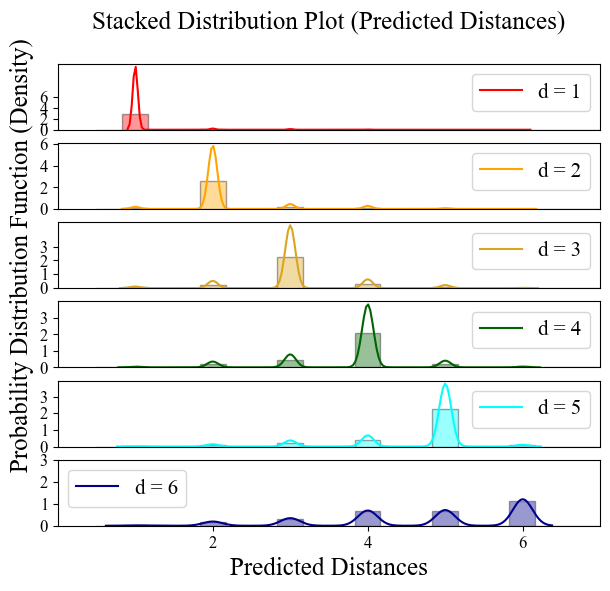

In [16]:
#====================================================================================================#
#num_classes=6
for i in range(num_classes):
    locals()["sim_dist_"+str(i+1)]=[]
#====================================================================================================#
for i in tqdm(range(len(y_pred))):
    distance = y_test[i] + 1
    prediction = y_pred[i] + 1
    locals()["sim_dist_"+str(distance)].append(prediction)

#====================================================================================================#
x=[]
for i in range(num_classes):
    x.append(np.array(locals()["sim_dist_"+str(i+1)]))
    
#====================================================================================================#
# For ipynb, remove warnings
import warnings
warnings.filterwarnings('ignore')

#====================================================================================================#
col_list=["red","orange","goldenrod","darkgreen","cyan","darkblue","purple","grey", "saddlebrown", "pink"]

#====================================================================================================#
def plot_type_1(plot_name):
    font = {'family' : "Times New Roman"}
    plt.rc('font', **font)
    g_all = plt.figure(figsize=(num_classes+1, num_classes))
    for i in range(num_classes):
        g = plt.subplot(num_classes, 1, i+1)
        #sns.kdeplot(x[i], bw = 0.01 , color="darkred")
        ax = sns.distplot(x[i], hist = 1, bins=np.arange(0.5,10.5,0.333) ,rug=False, kde=True, kde_kws={'bw':0.1},hist_kws=dict(ec="k"), color=col_list[i])
        #sns.distplot(x[i], hist = 1, bins=np.arange(0.5,10.5,0.333), rug=False, kde=True, kde_kws={'bw':0.2},hist_kws=dict(ec="k"), color=col_list[i])
        #sns.distplot(x[i], hist = 1, bins=np.arange(0.5,10.5,0.333), rug=False, kde=True, kde_kws={'bw':0.5},hist_kws=dict(ec="k"), color=col_list[i])
        #--------------------------------------------------#
        g.set(xlabel=None)
        g.set(ylabel=None)  
        #--------------------------------------------------#
        g.legend(labels=["d = "+ str(i+1)], fontsize=15)
        #--------------------------------------------------#
        g.set_yticks([0,1,2,3])
        g.set(yticklabels=[0,1,2,3])
        g.set_yticks([0,2,4,6]) if (i == 0 or i == 1) else 0
        g.set(yticklabels=[0,2,4,6]) if (i == 0 or i == 1) else 0
        #--------------------------------------------------#
        g.set_xticks([])
        g.set_xticks([2,4,6]) if i == num_classes-1 else 0
        g.set(xticklabels=[2,4,6]) if i == num_classes-1 else 0
        #--------------------------------------------------#
        g.tick_params(axis="y", labelsize=12)
        g.tick_params(axis="x", labelsize=12)
        #--------------------------------------------------#
        g.set_xlim((0, num_classes+1))
        #g.set_ylim((0,2))
        #g.set_ylim((0,3)) if (i == 0 or i == 1) else 0
        #--------------------------------------------------#
        g.set_title("Stacked Distribution Plot (Predicted Distances)\n", fontsize=18) if i == 0 else 0
        g.set_ylabel("Probability Distribution Function (Density)", fontsize=18) if i == round(num_classes/2)-1 else 0
        g.set_xlabel("Predicted Distances", fontsize=18) if i == num_classes-1 else 0
        #--------------------------------------------------#
    plt.show()
    g_all.savefig(results_sub_folder / (output_file_header + ".10_StackedDistn_"+plot_name+".png") , dpi=1000 ) 
    mpl.rcParams.update(mpl.rcParamsDefault)
    return
#====================================================================================================#
plot_name = "PredictedDistance"
plot_type_1("PredictedDistance")

In [17]:
# Compute Spearman's R
print ("R_Prediction = ", round(corrcoef(y_pred,y_test)[1,0],3))

R_Prediction =  0.869


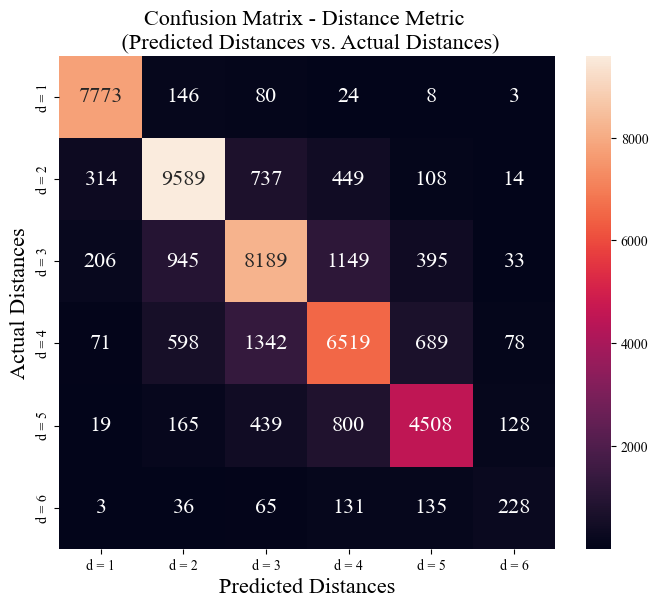

In [18]:
y_pred_list = y_pred
cm=confusion_matrix(y_test, y_pred_list)
confusion_matrix_df = pd.DataFrame(cm).rename(columns=idx2class, index=idx2class)
#--------------------------------------------------#
font = {'family' : "Times New Roman"}
plt.rc('font', **font)
#--------------------------------------------------#
fig = plt.figure(figsize=(8,6.4))
ax = sns.heatmap(confusion_matrix_df, annot=True, fmt="d", annot_kws={"fontsize":16})
#sns.heatmap(confusion_matrix_df, cmap="Reds", center=550, annot=True, fmt="d", annot_kws={"fontsize":16})
# labels, title and ticks
ax.set_xlabel('Predicted Distances', fontsize = 16)
ax.set_ylabel('Actual Distances', fontsize = 16)
ax.set_title('Confusion Matrix - Distance Metric \n (Predicted Distances vs. Actual Distances)', fontsize = 16)
ax.xaxis.set_ticklabels(["d = " + str(i+1) for i in range(num_classes)])
ax.yaxis.set_ticklabels(["d = " + str(i+1) for i in range(num_classes)])
plt.show()
#--------------------------------------------------#
fig.savefig(results_sub_folder / (output_file_header + ".10_HeatMapCM_" +plot_name+".png" ) , dpi=1000 ) 
mpl.rcParams.update(mpl.rcParamsDefault)
#--------------------------------------------------#

In [19]:
print(classification_report(y_test, y_pred_list)) 

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      8034
           1       0.84      0.86      0.85     11211
           2       0.75      0.75      0.75     10917
           3       0.72      0.70      0.71      9297
           4       0.77      0.74      0.76      6059
           5       0.47      0.38      0.42       598

    accuracy                           0.80     46116
   macro avg       0.75      0.73      0.74     46116
weighted avg       0.80      0.80      0.80     46116



### 10.3.12 Visualize how BAD Similarity Score have Characterized Reaction Distances (baseline)

Below shows similarity scores poor characterization of reaction distances.

Similarity Scores are calculated for pairs of compounds with distance information already extracted from MetaNetX compound/reaction database. Different Similarity Metrics are used and shown below including, 

    * "top" 
    * "MACCS" 
    * "atom_pairs" 
    * "vec_pairs" 
    * "torsions" 
    * "ECFP" 
    * "FCFP"

Values of distances are often used to compute an estimated similarity. Similarity scores can then be converted to some "distance" value using the same formula. Here, we estimate "distances" based on each similarity scores and calculate the correlation between the estimated distances and actual reaction distances (minimum steps of reactions required to transform a group of precursors to a target). 

Similarities and distances are oftern converted to one another using the equation, 
![\Large similarity=\frac{1}{distance + 1}](https://latex.codecogs.com/svg.latex?\Large&space;similarity(\tau)=\frac{1}{distance(d)+1}) 


In [20]:
#====================================================================================================#
pickle_in1=open(saving_folder  / "Xtep07_paired_cmpds_list","rb")
paired_smiles_list=pickle.load(pickle_in1)
pickle_in1.close()
pickle_in2=open(saving_folder  / "Xtep07_all_pairs_list","rb")
all_pairs_list=pickle.load(pickle_in2)
pickle_in2.close()
#====================================================================================================#
pickle_in1=open(saving_folder  / ("Xtep08_all_cmpds_"+ECFP_encodings),"rb")
all_smiles=pickle.load(pickle_in1)
pickle_in1.close()
pickle_in2=open(saving_folder  / ("Xtep08_all_ecfps_"+ECFP_encodings),"rb")
all_ecfps=pickle.load(pickle_in2)
pickle_in2.close()
pickle_in3=open(saving_folder  / ("Xtep08_all_cmpds_ecfps_dict_"+ECFP_encodings),"rb")
all_smiles_ecfps_dict=pickle.load(pickle_in3)
pickle_in3.close()
#====================================================================================================#
shuffle(paired_smiles_list)


In [21]:
#====================================================================================================#
def plot_stacked_distribution_similarity_scores(similarity_metric="ECFP", plot_name="Similarity"):
    dis_list=[]
    sim_list=[]
    sim_inferred_list=[]
    dis_inferred_list=[]
    count_x=0
    for one_pair_info in tqdm(paired_smiles_list): #[   [ { fr{}, fr{} },d ],   [ { fr{}, fr{} },d ],  [{{},{}},d], ....  ]
        count_x+=1
        #print count_x
        if count_x>=200000:
            break
        if len(list(list(one_pair_info[0])))==2:
            score = maxsimscore(list(list(one_pair_info[0])[0]), list(list(one_pair_info[0])[1]), similarity_metric)
            if score != 0:
                #--------------------------------------------------#
                distance = one_pair_info[1] if one_pair_info[1] <= num_classes-1 else num_classes
                dis_list.append(distance)
                #--------------------------------------------------#
                sim_inferred = 1/(distance+1.)
                sim_inferred_list.append(sim_inferred)
                #--------------------------------------------------#
                similarity=score
                sim_list.append(similarity)
                #--------------------------------------------------#
                dis_inferred = round(1./(similarity + 0.16666) - 1) + 1
                dis_inferred_list.append(dis_inferred)
    #====================================================================================================#
    #num_classes=10
    for i in range(num_classes):
        locals()["sim_dist_"+str(i+1)]=[]
    #====================================================================================================#
    for i in tqdm(range(len(dis_list))):
        distance = dis_list[i] if dis_list[i]<= num_classes-1 else num_classes
        prediction = sim_list[i]
        locals()["sim_dist_"+str(distance)].append(prediction)
    #====================================================================================================#
    x=[]
    for i in range(num_classes):
        x.append(np.array(locals()["sim_dist_"+str(i+1)]))
    #====================================================================================================#
    warnings.filterwarnings('ignore')
    #====================================================================================================#
    col_list=["red", "orange", "goldenrod", "darkgreen", "cyan", "darkblue", "purple", "grey", "saddlebrown", "pink"]
    #====================================================================================================#
    def plot_type_2(plot_name):
        font = {'family' : "Times New Roman"}
        plt.rc('font', **font)
        g_all = plt.figure(figsize=(num_classes+1,num_classes))
        for i in range(num_classes):
            g = plt.subplot(num_classes, 1, i+1)
            #sns.kdeplot(x[i], bw = 0.01 , color="darkred")
            #sns.distplot(x[i], hist = 1, bins=np.arange(0.5,10.5,0.333), rug=False, kde=True, kde_kws={'bw':0.1},hist_kws=dict(ec="k"), color=col_list[i])
            sns.distplot(x[i], hist = 1, bins=40, rug=False, kde=True, kde_kws={'bw':0.05},hist_kws=dict(ec="k"), color=col_list[i])
            #--------------------------------------------------#
            g.legend(labels=["d = "+ str(i+1)], fontsize=15)
            #--------------------------------------------------#
            g.set(xlabel=None)
            g.set(ylabel=None)
            #--------------------------------------------------#
            #g.set_yticks([0,1,2,3])
            #g.set(yticklabels=[0,1,2,3])
            #--------------------------------------------------#
            g.set_xticks([])
            g.set_xticks([0,0.2,0.4,0.6,0.8,1]) if i == num_classes - 1 else 0
            g.set(xticklabels=[0,0.2,0.4,0.6,0.8,1]) if i == num_classes - 1 else 0
            #--------------------------------------------------#
            g.set_xlim((0,1))
            #g.set_ylim((0,4))
            #--------------------------------------------------#
            g.tick_params(axis="x", labelsize=12)
            g.tick_params(axis="y", labelsize=12)
            #--------------------------------------------------#
            g.set_title("Stacked Distribution Plot (Similarity Scores)\n", fontsize=18) if i == 0 else 0
            g.set_ylabel("Probability Distribution Function (Density)", fontsize=18) if i == int(num_classes/2.)-1 else 0
            g.set_xlabel("Similarity Scores", fontsize=18) if i == num_classes - 1 else 0

        plt.show()
        g_all.savefig(results_sub_folder / (output_file_header + ".12_StackedDistn_" + plot_name + "_" + similarity_metric+".png") , dpi=1000 ) 
        mpl.rcParams.update(mpl.rcParamsDefault)
        return
    #====================================================================================================#
    plot_type_2(plot_name)
    #====================================================================================================#
    # Compute Spearman's R
    print ("Compute spearman's R for Distances (Real Distances vs. Inferred Distances) ")
    print ("and Similarities (Similarity Scores vs. Inferred Similarities). ")
    print ("Similarity Metric: ", similarity_metric)
    print ("R_Similarity = ", round(corrcoef(sim_list,sim_inferred_list)[1,0],3))
    print ("R_Distance = ", round(corrcoef(dis_list,dis_inferred_list)[1,0],3))
    #====================================================================================================#
    # Compute Spearman's R
    #--------------------------------------------------#
    font = {'family' : "Times New Roman"}
    plt.rc('font', **font)
    #--------------------------------------------------#
    cm=confusion_matrix(dis_list,dis_inferred_list)
    confusion_matrix_df = pd.DataFrame(cm)
    #--------------------------------------------------#
    fig = plt.figure(figsize=(8,6.4))
    #ax = sns.heatmap(confusion_matrix_df, cmap="Reds", center=550, annot=True, fmt="d", annot_kws={"fontsize":16})
    ax = sns.heatmap(confusion_matrix_df, annot=True, fmt="d", annot_kws={"fontsize":16})
    ax.set_xlabel('Inferred Distances', fontsize = 16)
    ax.set_ylabel('Actual Distances', fontsize = 16)
    ax.set_title('Confusion Matrix \n (Similarity Inferred Distances vs. Actual Distances)', fontsize = 16)
    ax.xaxis.set_ticklabels(["d = " + str(i+1) for i in range(num_classes)])
    ax.yaxis.set_ticklabels(["d = " + str(i+1) for i in range(num_classes)])
    plt.show()
    #--------------------------------------------------#
    fig.savefig(results_sub_folder / (output_file_header + ".12_HeatMapCM_" + plot_name + "_" + similarity_metric+".png") , dpi=1000 )
    mpl.rcParams.update(mpl.rcParamsDefault)
    #====================================================================================================#
    print("\nClassification Report\n")
    print(classification_report(dis_list, dis_inferred_list)) 
    return

### ECFP-based Similarity Metric's Characterization of Reaction Distances

100%|████████████████████████████████████████████████████████████████████████| 96972/96972 [00:00<00:00, 763389.39it/s]


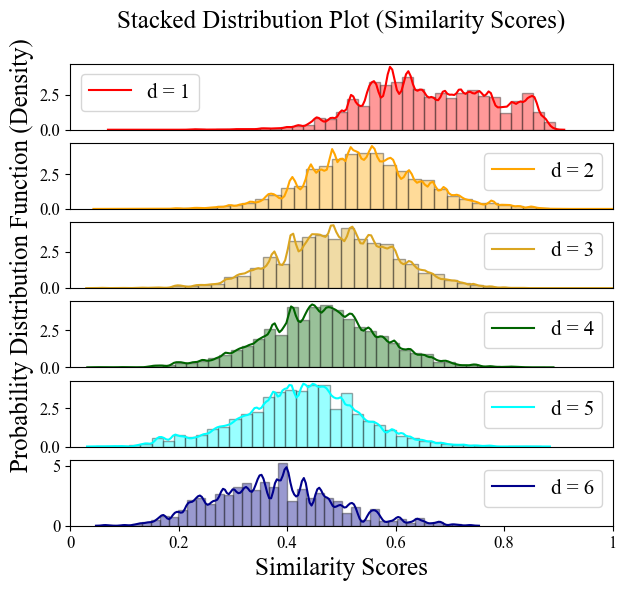

Compute spearman's R for Distances (Real Distances vs. Inferred Distances) 
and Similarities (Similarity Scores vs. Inferred Similarities). 
Similarity Metric:  ECFP
R_Similarity =  0.586
R_Distance =  0.462


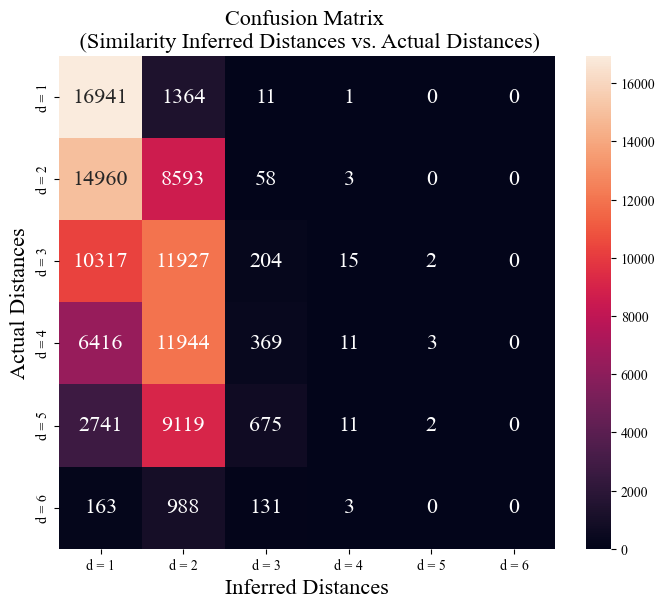


Classification Report

              precision    recall  f1-score   support

           1       0.33      0.92      0.49     18317
           2       0.20      0.36      0.25     23614
           3       0.14      0.01      0.02     22465
           4       0.25      0.00      0.00     18743
           5       0.29      0.00      0.00     12548
           6       0.00      0.00      0.00      1285

    accuracy                           0.27     96972
   macro avg       0.20      0.22      0.13     96972
weighted avg       0.23      0.27      0.16     96972



In [22]:
#====================================================================================================#
plot_stacked_distribution_similarity_scores(similarity_metric="ECFP", plot_name="Similarity")

### Other Similarity Metric's Characterization of Reaction Distances

100%|████████████████████████████████████████████████████████████████████████| 96972/96972 [00:00<00:00, 734469.38it/s]


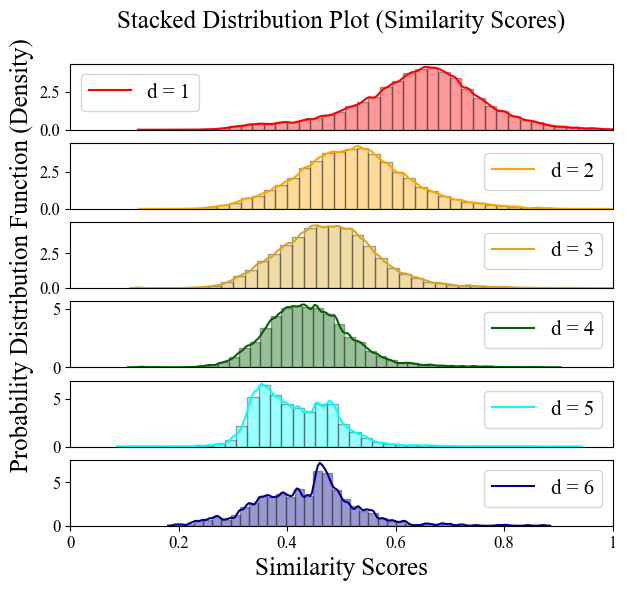

Compute spearman's R for Distances (Real Distances vs. Inferred Distances) 
and Similarities (Similarity Scores vs. Inferred Similarities). 
Similarity Metric:  top
R_Similarity =  0.609
R_Distance =  0.508


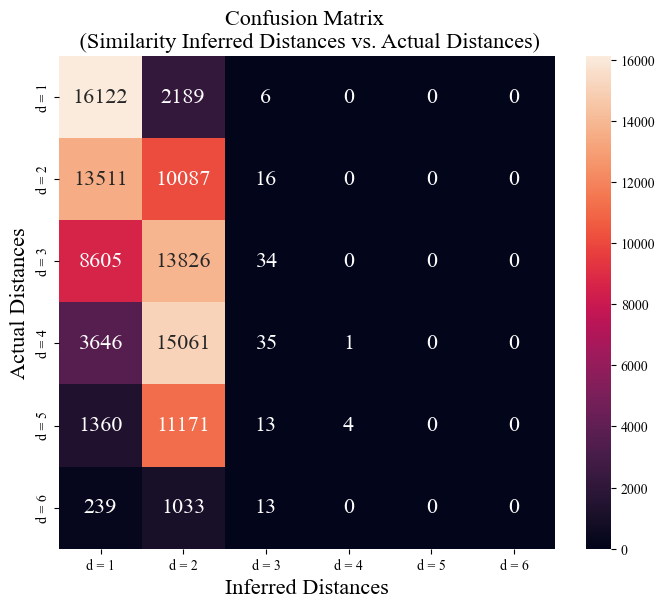


Classification Report

              precision    recall  f1-score   support

           1       0.37      0.88      0.52     18317
           2       0.19      0.43      0.26     23614
           3       0.29      0.00      0.00     22465
           4       0.20      0.00      0.00     18743
           5       0.00      0.00      0.00     12548
           6       0.00      0.00      0.00      1285

    accuracy                           0.27     96972
   macro avg       0.18      0.22      0.13     96972
weighted avg       0.22      0.27      0.16     96972



In [23]:
#====================================================================================================#
plot_stacked_distribution_similarity_scores(similarity_metric="top", plot_name="Similarity")

100%|████████████████████████████████████████████████████████████████████████| 96972/96972 [00:00<00:00, 728948.70it/s]


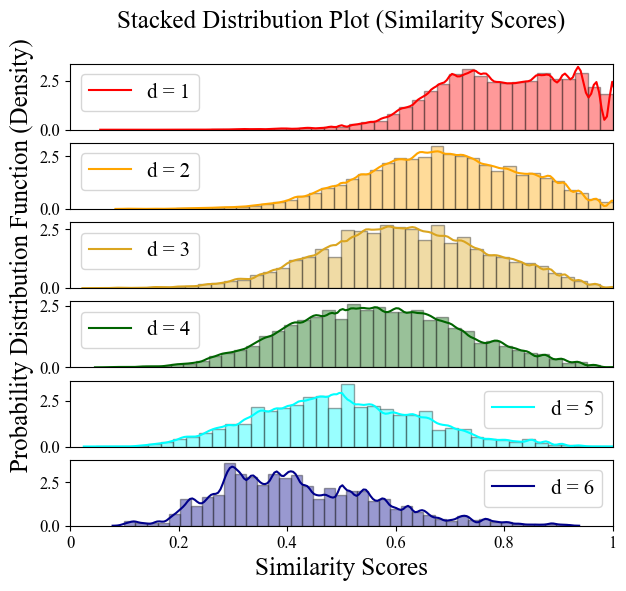

Compute spearman's R for Distances (Real Distances vs. Inferred Distances) 
and Similarities (Similarity Scores vs. Inferred Similarities). 
Similarity Metric:  MACCS
R_Similarity =  0.546
R_Distance =  0.416


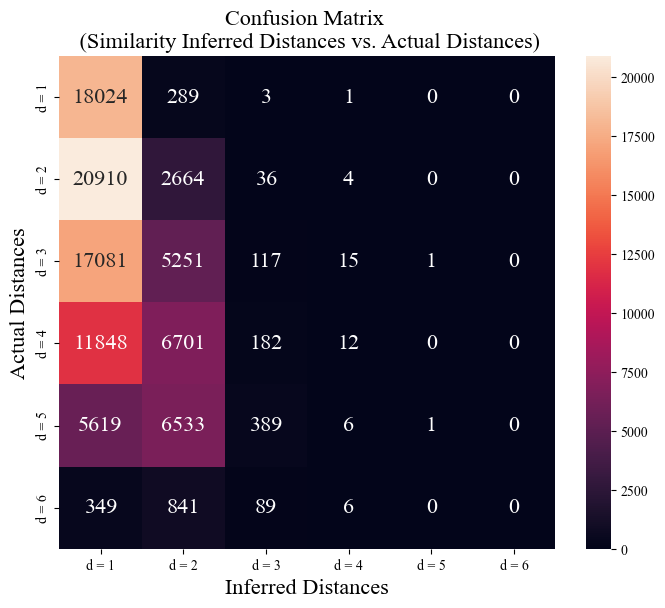


Classification Report

              precision    recall  f1-score   support

           1       0.24      0.98      0.39     18317
           2       0.12      0.11      0.12     23614
           3       0.14      0.01      0.01     22465
           4       0.27      0.00      0.00     18743
           5       0.50      0.00      0.00     12548
           6       0.00      0.00      0.00      1285

    accuracy                           0.21     96972
   macro avg       0.21      0.18      0.09     96972
weighted avg       0.23      0.21      0.10     96972



In [24]:
#====================================================================================================#
plot_stacked_distribution_similarity_scores(similarity_metric="MACCS", plot_name="Similarity")

100%|████████████████████████████████████████████████████████████████████████| 96972/96972 [00:00<00:00, 702534.17it/s]


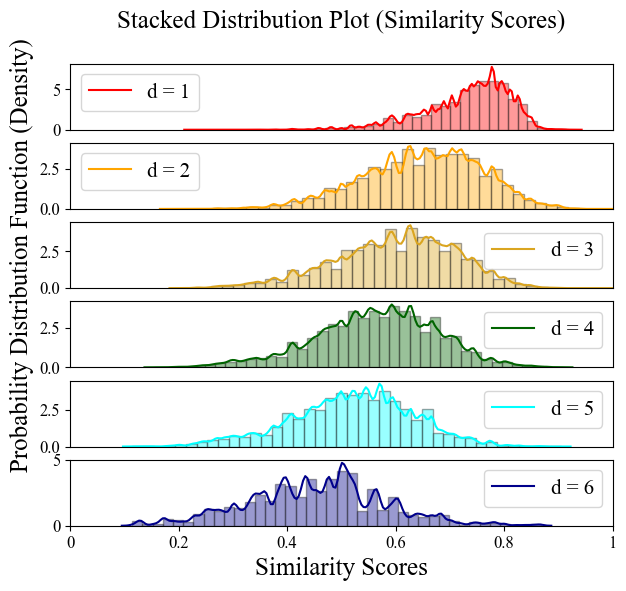

Compute spearman's R for Distances (Real Distances vs. Inferred Distances) 
and Similarities (Similarity Scores vs. Inferred Similarities). 
Similarity Metric:  FCFP
R_Similarity =  0.541
R_Distance =  0.354


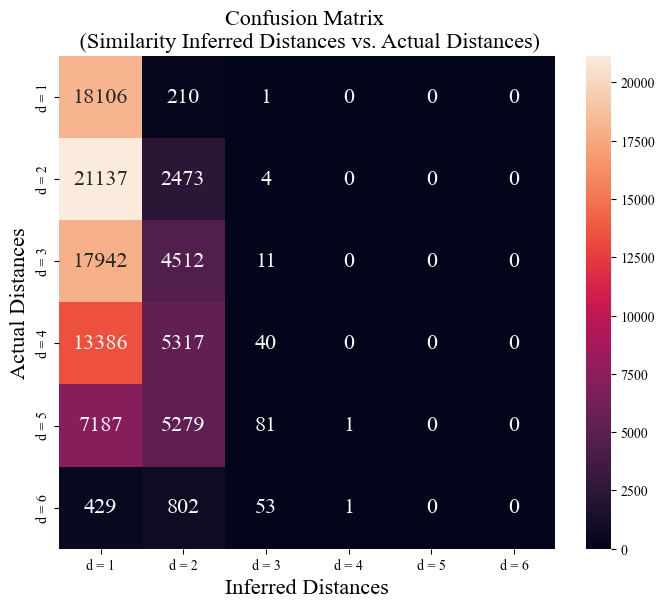


Classification Report

              precision    recall  f1-score   support

           1       0.23      0.99      0.38     18317
           2       0.13      0.10      0.12     23614
           3       0.06      0.00      0.00     22465
           4       0.00      0.00      0.00     18743
           5       0.00      0.00      0.00     12548
           6       0.00      0.00      0.00      1285

    accuracy                           0.21     96972
   macro avg       0.07      0.18      0.08     96972
weighted avg       0.09      0.21      0.10     96972



In [25]:
#====================================================================================================#
plot_stacked_distribution_similarity_scores(similarity_metric="FCFP", plot_name="Similarity")

100%|████████████████████████████████████████████████████████████████████████| 96953/96953 [00:00<00:00, 728800.65it/s]


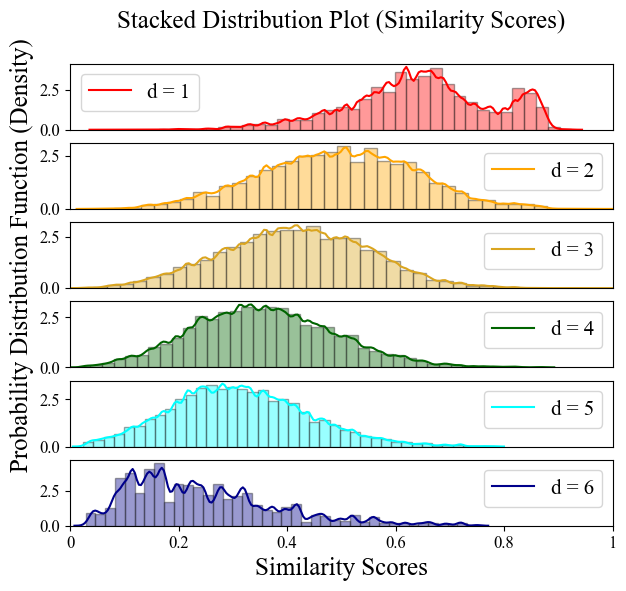

Compute spearman's R for Distances (Real Distances vs. Inferred Distances) 
and Similarities (Similarity Scores vs. Inferred Similarities). 
Similarity Metric:  atom_pairs
R_Similarity =  0.638
R_Distance =  0.54


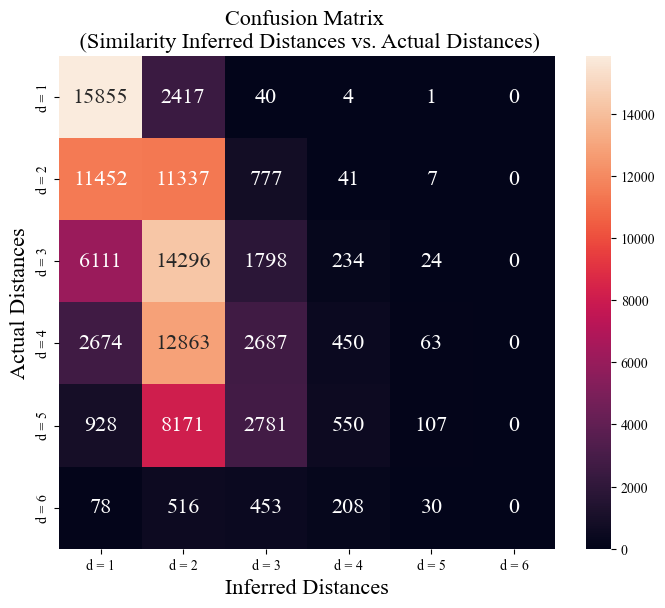


Classification Report

              precision    recall  f1-score   support

           1       0.43      0.87      0.57     18317
           2       0.23      0.48      0.31     23614
           3       0.21      0.08      0.12     22463
           4       0.30      0.02      0.04     18737
           5       0.46      0.01      0.02     12537
           6       0.00      0.00      0.00      1285

    accuracy                           0.30     96953
   macro avg       0.27      0.24      0.18     96953
weighted avg       0.30      0.30      0.22     96953



In [26]:
#====================================================================================================#
plot_stacked_distribution_similarity_scores(similarity_metric="atom_pairs", plot_name="Similarity")

100%|████████████████████████████████████████████████████████████████████████| 96953/96953 [00:00<00:00, 745602.95it/s]


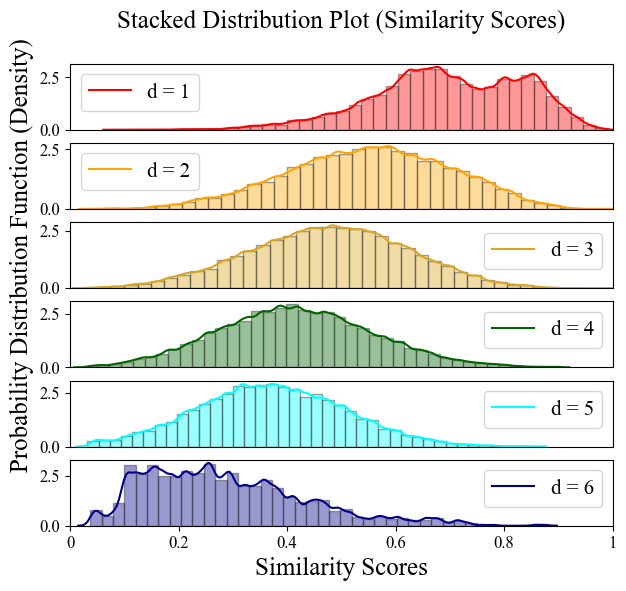

Compute spearman's R for Distances (Real Distances vs. Inferred Distances) 
and Similarities (Similarity Scores vs. Inferred Similarities). 
Similarity Metric:  vec_pairs
R_Similarity =  0.604
R_Distance =  0.495


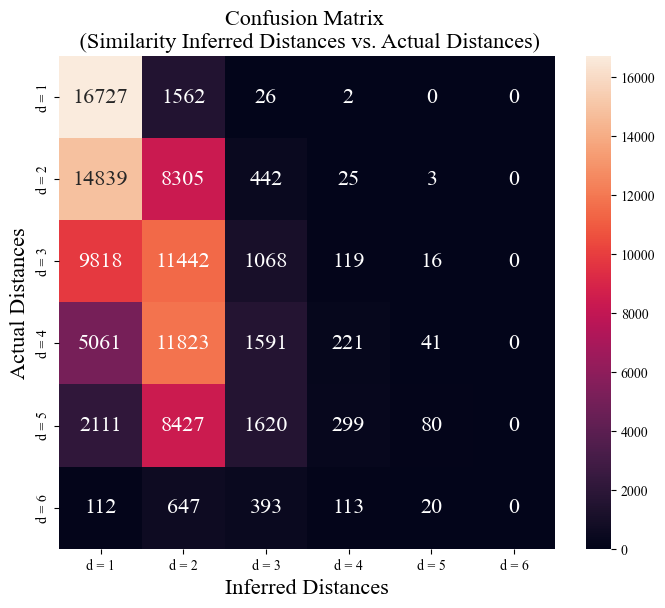


Classification Report

              precision    recall  f1-score   support

           1       0.34      0.91      0.50     18317
           2       0.20      0.35      0.25     23614
           3       0.21      0.05      0.08     22463
           4       0.28      0.01      0.02     18737
           5       0.50      0.01      0.01     12537
           6       0.00      0.00      0.00      1285

    accuracy                           0.27     96953
   macro avg       0.26      0.22      0.14     96953
weighted avg       0.28      0.27      0.18     96953



In [27]:
#====================================================================================================#
plot_stacked_distribution_similarity_scores(similarity_metric="vec_pairs", plot_name="Similarity")

100%|████████████████████████████████████████████████████████████████████████| 61203/61203 [00:00<00:00, 719946.12it/s]


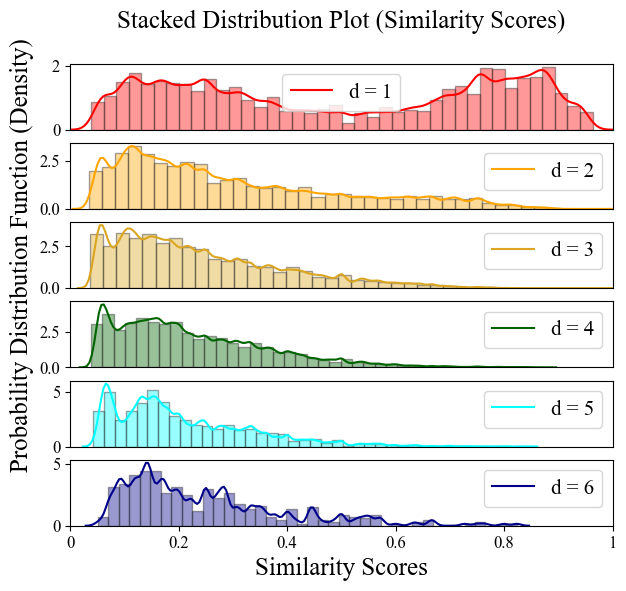

Compute spearman's R for Distances (Real Distances vs. Inferred Distances) 
and Similarities (Similarity Scores vs. Inferred Similarities). 
Similarity Metric:  torsions
R_Similarity =  0.463
R_Distance =  0.308


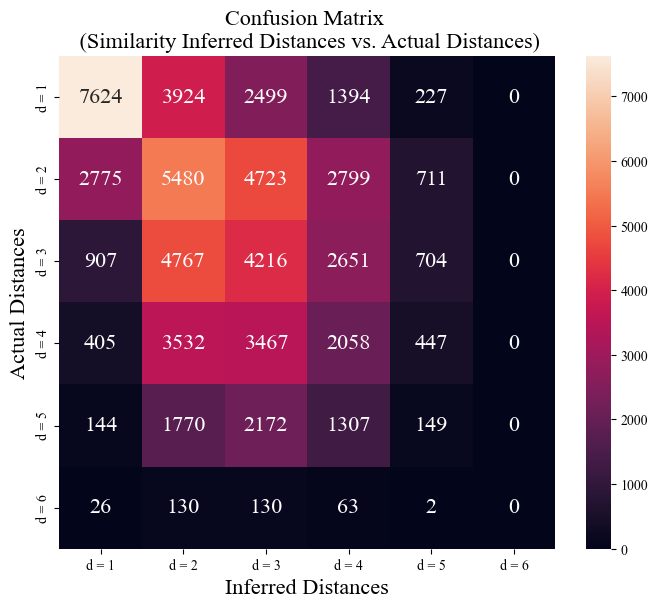


Classification Report

              precision    recall  f1-score   support

           1       0.64      0.49      0.55     15668
           2       0.28      0.33      0.30     16488
           3       0.25      0.32      0.28     13245
           4       0.20      0.21      0.20      9909
           5       0.07      0.03      0.04      5542
           6       0.00      0.00      0.00       351

    accuracy                           0.32     61203
   macro avg       0.24      0.23      0.23     61203
weighted avg       0.33      0.32      0.32     61203



In [28]:
#====================================================================================================#
plot_stacked_distribution_similarity_scores(similarity_metric="torsions", plot_name="Similarity")